In [10]:
# Import packages
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import yfinance as yf
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings

# Import modules
import trading_strategies

## Processing user input

Here you can enter parameters of your trading intentions, namely the period you want to observe the strategies performance in, the amount you intend to trade with, and the ticker you want to trade. Warning: Your initial balance must be greater than the close price of the ticker at the start of the period you picked (no fractional trades).

In [6]:
# Specify the ticker:
ticker = input("Enter a ticker you want to trade with: ")

# Take user input for start date:
start_date_str = input("Enter the start date (YYYY-MM-DD): ")

# Take user input for end date:
end_date_str = input("Enter the end date (YYYY-MM-DD or 'today' if you want to the most recent data): ")

initial_balance = float(input("Enter the amount (in USD) you want to trade with: "))

# Check if the user entered 'today' for end date:
if end_date_str.lower() == 'today':
    end_date = datetime.today()
else:
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

# Convert user input date strings to datetime objects for start date:
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")

# Create a close price dataframe:
df = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    
# Check for missing values in the dataframe:
if df.isnull().values.any():
    print("Warning! Data for the requested ticker is not available for the whole period.")
else:
    print("Data downloaded successfully.")

Enter a ticker you want to trade with:  AQN
Enter the start date (YYYY-MM-DD):  2022-01-01
Enter the end date (YYYY-MM-DD or 'today' if you want to the most recent data):  today
Enter the amount (in USD) you want to trade with:  1000


[*********************100%%**********************]  1 of 1 completed
Data downloaded successfully.


# Trading Strategies

## Baseline strategies

### 1. Random Trading

Here you can see the plot of an approximate distribution of the results of the random trading method. You can also run a single simulation below to see a sample of how such strategy makes trades. It will describe the trades it made in your specified period along with the prices at which the trades were made.

In [18]:
warnings.filterwarnings("ignore", category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated", module="trading_strategies")
trading_strategies.random_trading(data = df, initial_balance = initial_balance, description = True)

Day 2: Bought 6 stocks at $14.29 each.
Day 3: Bought 3 stocks at $14.12 each.
Day 4: Sold 5 stocks at $14.08 each.
Day 5: Sold 1 stocks at $14.18 each.
Day 6: Sold 3 stocks at $14.02 each.
Day 7: Bought 3 stocks at $13.95 each.
Day 8: Sold 2 stocks at $13.94 each.
Day 9: Bought 3 stocks at $14.02 each.
Day 10: Bought 3 stocks at $13.84 each.
Day 11: Bought 8 stocks at $14.05 each.
Day 12: Sold 8 stocks at $14.16 each.
Day 13: Sold 5 stocks at $14.18 each.
Day 14: Sold 2 stocks at $14.02 each.
Day 15: Bought 6 stocks at $13.81 each.
Day 16: Bought 10 stocks at $13.68 each.
Day 17: Bought 8 stocks at $13.73 each.
Day 18: Sold 5 stocks at $13.80 each.
Day 19: Sold 3 stocks at $13.99 each.
Day 20: Bought 4 stocks at $14.29 each.
Day 21: Bought 4 stocks at $14.18 each.
Day 22: Bought 9 stocks at $14.29 each.
Day 23: Sold 13 stocks at $14.13 each.
Day 24: Sold 14 stocks at $14.04 each.
Day 25: Bought 5 stocks at $14.13 each.
Day 26: Bought 3 stocks at $14.14 each.
Day 27: Sold 3 stocks at $1

In [8]:
# Simulate trading cycles
trade_simulations = [trading_strategies.random_trading(data = df, initial_balance = initial_balance,
                                                       description = False) for i in range(1000)]

Text(0.5, 1.0, 'Avg: $913.04\nSD: $55.59')

<Figure size 1000x400 with 0 Axes>

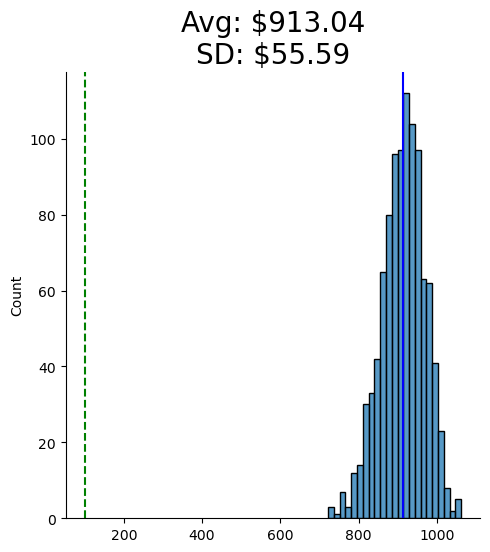

In [11]:
# Ignore FutureWarnings from seaborn and pandas
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

# Plot the trade simulations distribution
plt.figure(figsize=(10,4))
sns.displot(trade_simulations)
plt.axvline(np.mean(trade_simulations), color='b', linestyle='-')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(trade_simulations),2), round(np.std(trade_simulations),2)), fontsize=20)

### 2. Buy and Hold

In [13]:
# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated", module="trading_strategies")

trading_strategies.buy_and_hold(df, initial_balance)

Final balance: $452.21


## Data based strategies

### Moving Average 

In [14]:
# create a dataframe for the Moving Average strategy
df_ma = trading_strategies.MA_strategy(data = df, long_ma = 50, short_ma = 20)

<function matplotlib.pyplot.show(close=None, block=None)>

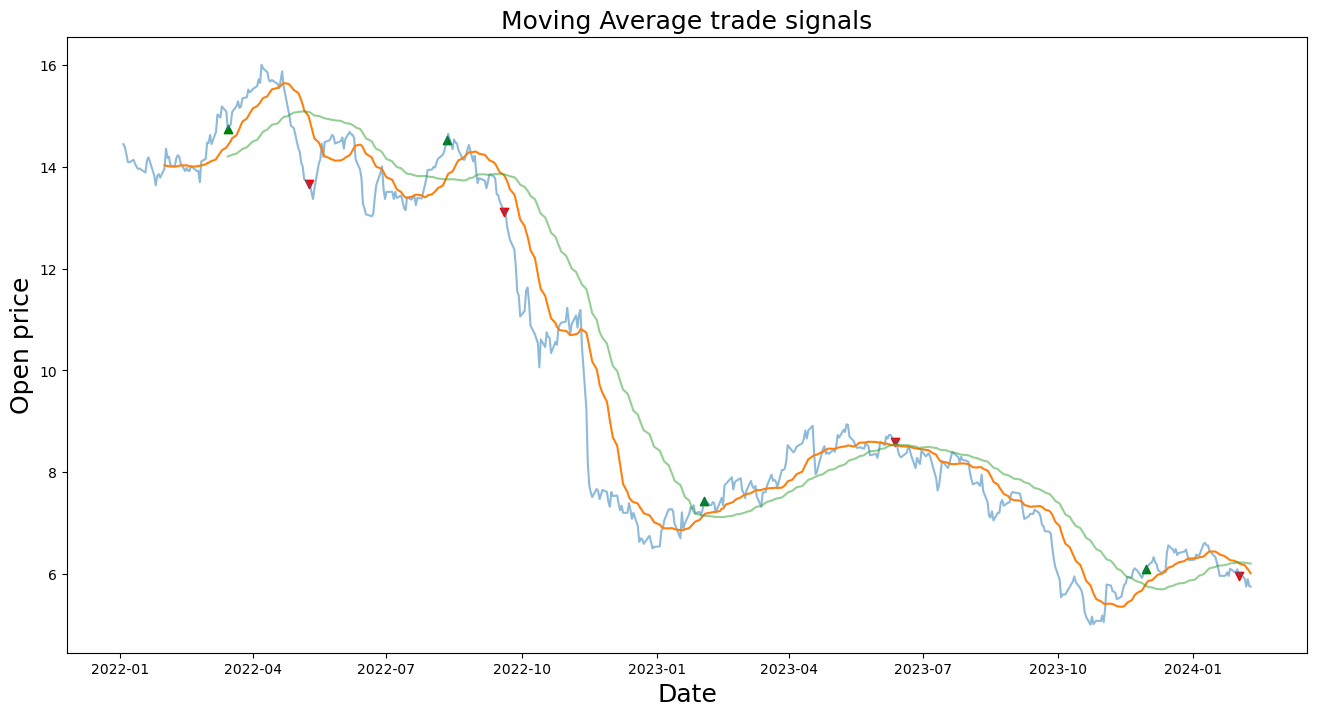

In [15]:
# Visualization of Buy and sell signals using Moving Average
plt.figure(figsize = (16,8))
plt.title("Moving Average trade signals", fontsize = 18)
plt.plot(df_ma["Open"], alpha = 0.5)
plt.plot(df_ma["ShortMA"], alpha = 1)
plt.plot(df_ma["LongMA"], alpha = 0.5)
plt.scatter(df_ma.index, df_ma["Buy"], alpha = 1, label = "Buy Signal", marker = "^", color = "green")
plt.scatter(df_ma.index, df_ma["Sell"], alpha = 1, label = "Sell Signal", marker = "v", color = "red")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Open price", fontsize = 18)
plt.show

### XGBoost Regression 

In [16]:
df_trading = trading_strategies.xgb_signals(df)

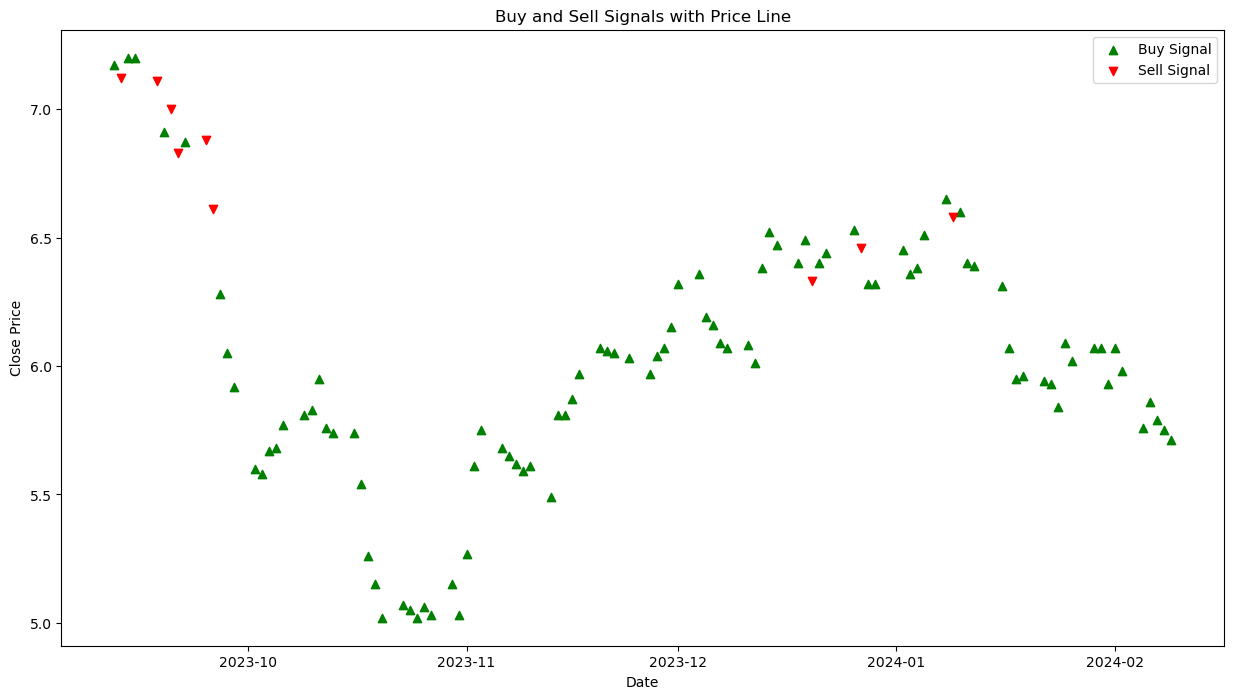

In [17]:
# Plot buy and sell signals
buy_signals = df_trading[df_trading['Trade_Signal'] == 1]
sell_signals = df_trading[df_trading['Trade_Signal'] == -1]

# Create a wider figure
plt.figure(figsize=(15, 8))

# Scatter plots for buy and sell signals
plt.scatter(buy_signals.index, buy_signals['Close_Price_On_Trade'], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['Close_Price_On_Trade'], marker='v', color='r', label='Sell Signal')

# Customize the plot
plt.title('Buy and Sell Signals with Price Line')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()